In [2]:
!pip install -q tf-nightly
!pip install -q tf-models-nightly

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
ERROR: google-api-core 1.22.3 has requirement google-auth<2.0dev,>=1.21.1, but you'll have google-auth 1.19.2 which is incompatible.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [8]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

In [9]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

In [10]:
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"

In [96]:
# glue, info = tfds.load('glue/mrpc', with_info=True,
#                        # It's small, load the whole dataset
#                        batch_size=-1)

my_glue_train={
    "sentence1":[
        tf.constant("The identical rovers will act as robotic geologists , searching for evidence of past water ."),
        tf.constant("one kitty is cute")
    ],
    "sentence2":[
        tf.constant("The rovers act as robotic geologists , moving on six wheels ."),
        tf.constant("a little cat is pretty")
    ],
    "label":tf.constant([0,1]),
}
# 数据下载不下来，手动造了一个格式差不多的

In [97]:
# glue_train = glue['train']

for key, value in my_glue_train.items():
  print(f"{key:9s}: {value[0].numpy()}")

sentence1: b'The identical rovers will act as robotic geologists , searching for evidence of past water .'
sentence2: b'The rovers act as robotic geologists , moving on six wheels .'
label    : 0


In [98]:
# Set up tokenizer to generate Tensorflow dataset
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


In [99]:
tokens = tokenizer.tokenize("Hello TensorFlow!")
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

['hello', 'tensor', '##flow', '!']
[7592, 23435, 12314, 999]


In [100]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [101]:
input_mask = tf.ones_like([[0,10,1,0],[1,0,1,0]])

In [102]:
input_mask

<tf.Tensor: shape=(2, 4), dtype=int32, numpy=
array([[1, 1, 1, 1],
       [1, 1, 1, 1]], dtype=int32)>

In [103]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s.numpy()))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

# 因为传入的列表的长短不同，因此需要用tf.ragged.constant来转化成tensor
sentence1 = tf.ragged.constant([
    encode_sentence(s) for s in my_glue_train["sentence1"]])
sentence2 = tf.ragged.constant([
    encode_sentence(s) for s in my_glue_train["sentence2"]])

In [104]:
sentence1.__dict__

{'_values': <tf.Tensor: shape=(23,), dtype=int32, numpy=
 array([ 1996,  7235,  9819,  2097,  2552,  2004, 20478, 21334,  2015,
         1010,  6575,  2005,  3350,  1997,  2627,  2300,  1012,   102,
         2028, 14433,  2003, 10140,   102], dtype=int32)>,
 '_row_partition': tf.RowPartition(row_splits=tf.Tensor([ 0 18 23], shape=(3,), dtype=int64))}

In [105]:
print("Sentence1 shape:", sentence1.shape.as_list())
print("Sentence2 shape:", sentence2.shape.as_list())

Sentence1 shape: [2, None]
Sentence2 shape: [2, None]


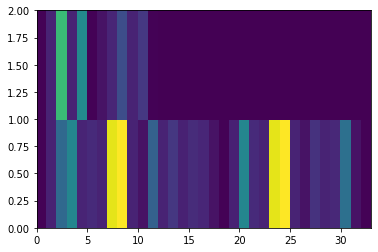

In [106]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)
_ = plt.pcolormesh(input_word_ids.to_tensor())

In [107]:
input_word_ids

<tf.RaggedTensor [[101, 1996, 7235, 9819, 2097, 2552, 2004, 20478, 21334, 2015, 1010, 6575, 2005, 3350, 1997, 2627, 2300, 1012, 102, 1996, 9819, 2552, 2004, 20478, 21334, 2015, 1010, 3048, 2006, 2416, 7787, 1012, 102], [101, 2028, 14433, 2003, 10140, 102, 1037, 2210, 4937, 2003, 3492, 102]]>

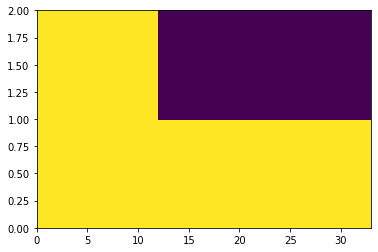

In [108]:
input_mask = tf.ones_like(input_word_ids).to_tensor() # tf.ones_like(input_word_ids)会返回一个ragedtensor，to tensor就会返回补0之后的tensor对象

plt.pcolormesh(input_mask)

In [109]:
input_mask

<tf.Tensor: shape=(2, 33), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>

In [110]:
tf.ones_like(input_word_ids)

<tf.RaggedTensor [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]>

In [111]:
# 就是拼接操作，0的部分是sentence1，1的部分是sentence2
type_cls = tf.zeros_like(cls)
type_s1 = tf.zeros_like(sentence1)
type_s2 = tf.ones_like(sentence2)
input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis=-1).to_tensor()

input_type_ids

<tf.Tensor: shape=(2, 33), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>

In [112]:
type_s2

<tf.RaggedTensor [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]>

In [113]:
def encode_sentence(s, tokenizer):
   tokens = list(tokenizer.tokenize(s.numpy())) # 改动
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(glue_dict, tokenizer):
  num_examples = len(glue_dict["sentence1"])
  
  sentence1 = tf.ragged.constant([
      encode_sentence(s, tokenizer)
      for s in glue_dict["sentence1"]]) # 改动
  sentence2 = tf.ragged.constant([
      encode_sentence(s, tokenizer)
       for s in glue_dict["sentence2"]]) # 改动

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
  input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor() # 利用这个to_tensor来补充0

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(sentence1)
  type_s2 = tf.ones_like(sentence2)
  input_type_ids = tf.concat(
      [type_cls, type_s1, type_s2], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [114]:
glue_train = bert_encode(my_glue_train, tokenizer)
glue_train_labels = my_glue_train['label']

In [115]:
glue_train 
# input_word_ids就是tokenized之后的文本
# input mask用来指定谁是padding
# input_type_ids用来指定谁是文本1谁是文本2

{'input_word_ids': <tf.Tensor: shape=(2, 33), dtype=int32, numpy=
 array([[  101,  1996,  7235,  9819,  2097,  2552,  2004, 20478, 21334,
          2015,  1010,  6575,  2005,  3350,  1997,  2627,  2300,  1012,
           102,  1996,  9819,  2552,  2004, 20478, 21334,  2015,  1010,
          3048,  2006,  2416,  7787,  1012,   102],
        [  101,  2028, 14433,  2003, 10140,   102,  1037,  2210,  4937,
          2003,  3492,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0]], dtype=int32)>,
 'input_mask': <tf.Tensor: shape=(2, 33), dtype=int32, numpy=
 array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(2, 33), dtype=int32, numpy=
 a

In [116]:
for key, value in glue_train.items():
  print(f'{key:15s} shape: {value.shape}')

print(f'glue_train_labels shape: {glue_train_labels.shape}')

input_word_ids  shape: (2, 33)
input_mask      shape: (2, 33)
input_type_ids  shape: (2, 33)
glue_train_labels shape: (2,)


In [117]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

In [118]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(
    bert_config, num_labels=2)

In [119]:
bert_classifier.summary()

Model: "bert_classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
bert_encoder_1 (BertEncoder)    [(None, None, 768),  109482240   input_word_ids[0][0]             
                                                                 input_mask[0][0]   

In [120]:
tf.keras.utils.plot_model(bert_classifier, show_shapes=True, dpi=48)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [121]:
glue_batch = {key: val[:10] for key, val in glue_train.items()}

bert_classifier(
    glue_batch, training=True
).numpy()

array([[ 0.14801878, -0.11110532],
       [ 0.05599343, -0.06263569]], dtype=float32)

In [122]:
glue_batch

{'input_word_ids': <tf.Tensor: shape=(2, 33), dtype=int32, numpy=
 array([[  101,  1996,  7235,  9819,  2097,  2552,  2004, 20478, 21334,
          2015,  1010,  6575,  2005,  3350,  1997,  2627,  2300,  1012,
           102,  1996,  9819,  2552,  2004, 20478, 21334,  2015,  1010,
          3048,  2006,  2416,  7787,  1012,   102],
        [  101,  2028, 14433,  2003, 10140,   102,  1037,  2210,  4937,
          2003,  3492,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0]], dtype=int32)>,
 'input_mask': <tf.Tensor: shape=(2, 33), dtype=int32, numpy=
 array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(2, 33), dtype=int32, numpy=
 a

In [ ]:
# 然后看明白模型的结构就可以了
# transformer encoding的第一个?指batch_size，第二个?指的是seq_len
# 那些个transformer是啥就没看了，不重要，可以看paper去